## Installation

### Required Packages:
- **transformers**: Hugging Face library for pre-trained Transformer models (GPT-2, BERT, etc.)
- **datasets**: Efficient data loading and processing for NLP tasks
- **torch**: PyTorch deep learning framework
- **accelerate**: Simplifies multi-GPU and mixed precision training
- **matplotlib & seaborn**: Data visualization libraries
- **pandas & numpy**: Data manipulation and numerical operations

The `-q` flag runs the installation quietly (less verbose output).

## Library Imports and Environment Setup

### Key Components:
1. **torch**: Core PyTorch functionality for tensor operations and neural networks
2. **AutoTokenizer**: Automatically loads the correct tokenizer for the model
3. **AutoModelForCausalLM**: Loads pre-trained causal language models (GPT-style)
4. **Trainer**: High-level API for training models with automatic optimization
5. **DataCollatorForLanguageModeling**: Handles batch preparation for language modeling

### Why Set Random Seeds?
Setting random seeds ensures reproducibility - running the code multiple times will produce the same results, which is crucial for scientific experiments and debugging.

In [ ]:
# Install required packages for Transformer-based text generation
# This may take 1-2 minutes depending on your internet connection
!pip install transformers datasets torch accelerate matplotlib seaborn pandas numpy -q

In [18]:
# Import necessary libraries
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    TrainingArguments, 
    Trainer,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.2.1+cu118


## 1. Data Loading and Preprocessing

### About WikiText-2 Dataset:

- **Source**: High-quality Wikipedia articles- **10% validation data**: Used to evaluate generalization (never seen during training)

- **Size**: ~2 million tokens (we'll use only 500 samples for speed)- **90% training data**: Used to update model weights

- **Format**: Raw text without tokenization### Train/Validation Split:

- **Purpose**: Language modeling benchmark dataset

- **Hyperparameter comparison**: Can test multiple configurations quickly

### Why Use a Small Subset?- **Educational focus**: Demonstrates concepts without requiring expensive hardware
- **Quick execution**: Full training in minutes, not hours

In [21]:
# Load a lightweight dataset - using a small subset for quick execution
print("Loading dataset...")

# Using the wikitext-2 dataset (small and fast to load)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

# Take only a small subset for quick training (500 examples)
dataset = dataset.select(range(min(500, len(dataset))))

# Split into train and validation
dataset = dataset.train_test_split(test_size=0.1, seed=42)

print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['test'])}")
print(f"\nSample text:\n{dataset['train'][0]['text'][:200]}...")

Loading dataset...
Training samples: 450
Validation samples: 50

Sample text:
...


### Tokenization Process

**What happens during tokenization?**
1. **Text → Tokens**: Break text into subword pieces
2. **Tokens → IDs**: Convert each token to its vocabulary index
3. **Truncation**: Cut sequences longer than max_length (128 tokens)
4. **Padding**: Add padding tokens to make all sequences the same length

**Why max_length=128?**
- Shorter sequences = faster training and less memory
- 128 tokens ≈ 80-100 words (depends on text)
- Sufficient for demonstrating concepts
- Full models often use 512, 1024, or 2048 tokens

**Batched Processing:**
- Processes multiple examples at once (faster than one-by-one)
- Removes original text column (only keep token IDs)

## 2. Model and Tokenizer Setup

### What is DistilGPT-2?
DistilGPT-2 is a compressed version of OpenAI's GPT-2 created through knowledge distillation:
- **Size**: 82M parameters (vs. 124M in GPT-2)
- **Speed**: 60% faster inference

- **Performance**: Retains ~97% of GPT-2's capabilities- Example: "unhappiness" → ["un", "happiness"] or ["unhappiness"] if common

- **Memory**: 40% smaller, fits on most hardware- Rare words are split into subword pieces

- Frequently occurring subwords get their own tokens

### Why Use a Tokenizer?GPT-2 uses BPE tokenization:

Neural networks work with numbers, not text. A tokenizer:### Byte Pair Encoding (BPE):

1. **Breaks text into tokens**: "Hello world" → ["Hello", " world"]

2. **Converts to IDs**: ["Hello", " world"] → [15496, 995]4. **Vocabulary**: DistilGPT-2 has 50,257 unique tokens
3. **Handles special tokens**: Start, end, padding tokens

In [23]:
# Load pre-trained model and tokenizer
model_name = "distilgpt2"  # Lightweight model (82M parameters)

print(f"Loading {model_name} model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set padding token (GPT-2 doesn't have one by default)
tokenizer.pad_token = tokenizer.eos_token

print(f"Vocabulary size: {len(tokenizer)}")
print(f"Model loaded successfully!")

Loading distilgpt2 model and tokenizer...
Vocabulary size: 50257
Model loaded successfully!


In [24]:
# Tokenize the dataset
def tokenize_function(examples):
    """
    Tokenizes text data and prepares it for causal language modeling.
    Truncates sequences to max_length for memory efficiency.
    """
    return tokenizer(
        examples["text"], 
        truncation=True, 
        max_length=128,  # Short sequences for quick training
        padding="max_length"
    )

print("Tokenizing dataset...")
tokenized_dataset = dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=dataset["train"].column_names
)

print("Tokenization complete!")
print(f"Sample tokenized input shape: {len(tokenized_dataset['train'][0]['input_ids'])}")

Tokenizing dataset...


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenization complete!
Sample tokenized input shape: 128


## 3. Data Collator for Language Modeling

### What is a Data Collator?
A data collator prepares batches of data during training. It handles:
1. **Grouping examples**: Combines individual samples into batches
2. **Creating labels**: For language modeling, labels are shifted inputs

3. **Handling variable lengths**: Ensures consistent batch dimensionsModel learns: Given "The", predict "cat". Given "The cat", predict "sat", etc.

```

### Causal vs Masked Language Modeling:Labels: [cat] [sat] [on] [mat] [EOS]

Input:  [The] [cat] [sat] [on] [mat]

**Causal LM (GPT-style)** - What we're using:```

- Predicts the NEXT token given previous tokensFor causal LM, labels are inputs shifted by 1 position:

- Model can only see past, not future (autoregressive)### Label Creation:

- Input: "The cat sat" → Target: "cat sat on"

- Use case: Text generation, completion- Use case: Understanding, classification

- Input: "The [MASK] sat" → Target: "cat"

**Masked LM (BERT-style)**:- Predicts MASKED tokens using both past and future context

In [25]:
# Data collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

print("Data collator configured for causal language modeling")

Data collator configured for causal language modeling


## 4. Hyperparameter Configurations

In [26]:
# Define hyperparameter configurations to test
hyperparameter_configs = [
    # Config 1: Small learning rate, small batch
    {
        "name": "Small LR + Small Batch",
        "learning_rate": 1e-5,
        "batch_size": 4,
        "num_epochs": 2
    },
    # Config 2: Medium learning rate, medium batch
    {
        "name": "Medium LR + Medium Batch",
        "learning_rate": 5e-5,
        "batch_size": 8,
        "num_epochs": 2
    },
    # Config 3: Large learning rate, larger batch
    {
        "name": "Large LR + Large Batch",
        "learning_rate": 1e-4,
        "batch_size": 16,
        "num_epochs": 2
    }
]

print("Hyperparameter configurations:")
for i, config in enumerate(hyperparameter_configs, 1):
    print(f"\nConfig {i}: {config['name']}")
    print(f"  - Learning Rate: {config['learning_rate']}")
    print(f"  - Batch Size: {config['batch_size']}")
    print(f"  - Epochs: {config['num_epochs']}")

Hyperparameter configurations:

Config 1: Small LR + Small Batch
  - Learning Rate: 1e-05
  - Batch Size: 4
  - Epochs: 2

Config 2: Medium LR + Medium Batch
  - Learning Rate: 5e-05
  - Batch Size: 8
  - Epochs: 2

Config 3: Large LR + Large Batch
  - Learning Rate: 0.0001
  - Batch Size: 16
  - Epochs: 2


## 5. Training Function

In [27]:
def train_model(config):
    """
    Train a model with the given hyperparameter configuration.
    
    Args:
        config: Dictionary containing hyperparameters
    
    Returns:
        Dictionary with training results and metrics
    """
    print(f"\n{'='*60}")
    print(f"Training with: {config['name']}")
    print(f"{'='*60}")
    
    # Load a fresh model for each configuration
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.to(device)
    
    # Configure training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{config['name'].replace(' ', '_')}",
        eval_strategy="epoch",
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        num_train_epochs=config["num_epochs"],
        weight_decay=0.01,
        logging_steps=10,
        save_strategy="no",  # Don't save checkpoints to save time
        report_to="none",  # Disable wandb/tensorboard
        seed=42
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        data_collator=data_collator,
    )
    
    # Train and measure time
    start_time = time()
    train_result = trainer.train()
    training_time = time() - start_time
    
    # Evaluate on validation set
    eval_results = trainer.evaluate()
    
    # Calculate perplexity (lower is better)
    perplexity = np.exp(eval_results["eval_loss"])
    
    # Collect results
    results = {
        "config_name": config["name"],
        "learning_rate": config["learning_rate"],
        "batch_size": config["batch_size"],
        "num_epochs": config["num_epochs"],
        "train_loss": train_result.training_loss,
        "eval_loss": eval_results["eval_loss"],
        "perplexity": perplexity,
        "training_time": training_time,
        "model": model
    }
    
    print(f"\nResults:")
    print(f"  Training Loss: {results['train_loss']:.4f}")
    print(f"  Validation Loss: {results['eval_loss']:.4f}")
    print(f"  Perplexity: {results['perplexity']:.2f}")
    print(f"  Training Time: {results['training_time']:.2f}s")
    
    return results

## 6. Train Models with Different Hyperparameters

Now we'll train the model with each configuration and collect results for analysis.

In [28]:
# Train models with different hyperparameters
all_results = []

for config in hyperparameter_configs:
    results = train_model(config)
    all_results.append(results)

print("\n" + "="*60)
print("All training runs completed!")
print("="*60)


Training with: Small LR + Small Batch


Epoch,Training Loss,Validation Loss
1,4.343600,4.740015
2,4.034000,4.621161



Results:
  Training Loss: 4.3892
  Validation Loss: 4.6212
  Perplexity: 101.61
  Training Time: 29.19s

Training with: Medium LR + Medium Batch


Epoch,Training Loss,Validation Loss
1,4.050300,4.210693
2,3.527000,4.097111



Results:
  Training Loss: 3.9482
  Validation Loss: 4.0971
  Perplexity: 60.17
  Training Time: 24.71s

Training with: Large LR + Large Batch


Epoch,Training Loss,Validation Loss
1,4.187300,3.955107
2,3.484100,3.855344



Results:
  Training Loss: 3.8408
  Validation Loss: 3.8553
  Perplexity: 47.24
  Training Time: 71.04s

All training runs completed!


## 7. Results Analysis and Visualization


In [29]:
# Create results DataFrame for easy analysis
results_df = pd.DataFrame([
    {
        "Configuration": r["config_name"],
        "Learning Rate": r["learning_rate"],
        "Batch Size": r["batch_size"],
        "Train Loss": r["train_loss"],
        "Validation Loss": r["eval_loss"],
        "Perplexity": r["perplexity"],
        "Training Time (s)": r["training_time"]
    }
    for r in all_results
])

print("\nHyperparameter Tuning Results Summary:")
print("="*80)
print(results_df.to_string(index=False))

# Find best configuration based on validation loss
best_config_idx = results_df["Validation Loss"].idxmin()
best_config = results_df.iloc[best_config_idx]

print(f"\n{'='*80}")
print(f"BEST CONFIGURATION: {best_config['Configuration']}")
print(f"  - Learning Rate: {best_config['Learning Rate']}")
print(f"  - Batch Size: {best_config['Batch Size']}")
print(f"  - Validation Loss: {best_config['Validation Loss']:.4f}")
print(f"  - Perplexity: {best_config['Perplexity']:.2f}")
print(f"{'='*80}")


Hyperparameter Tuning Results Summary:
           Configuration  Learning Rate  Batch Size  Train Loss  Validation Loss  Perplexity  Training Time (s)
  Small LR + Small Batch        0.00001           4    4.389166         4.621161  101.611982          29.189633
Medium LR + Medium Batch        0.00005           8    3.948177         4.097111   60.166201          24.707577
  Large LR + Large Batch        0.00010          16    3.840817         3.855344   47.244880          71.043487

BEST CONFIGURATION: Large LR + Large Batch
  - Learning Rate: 0.0001
  - Batch Size: 16
  - Validation Loss: 3.8553
  - Perplexity: 47.24


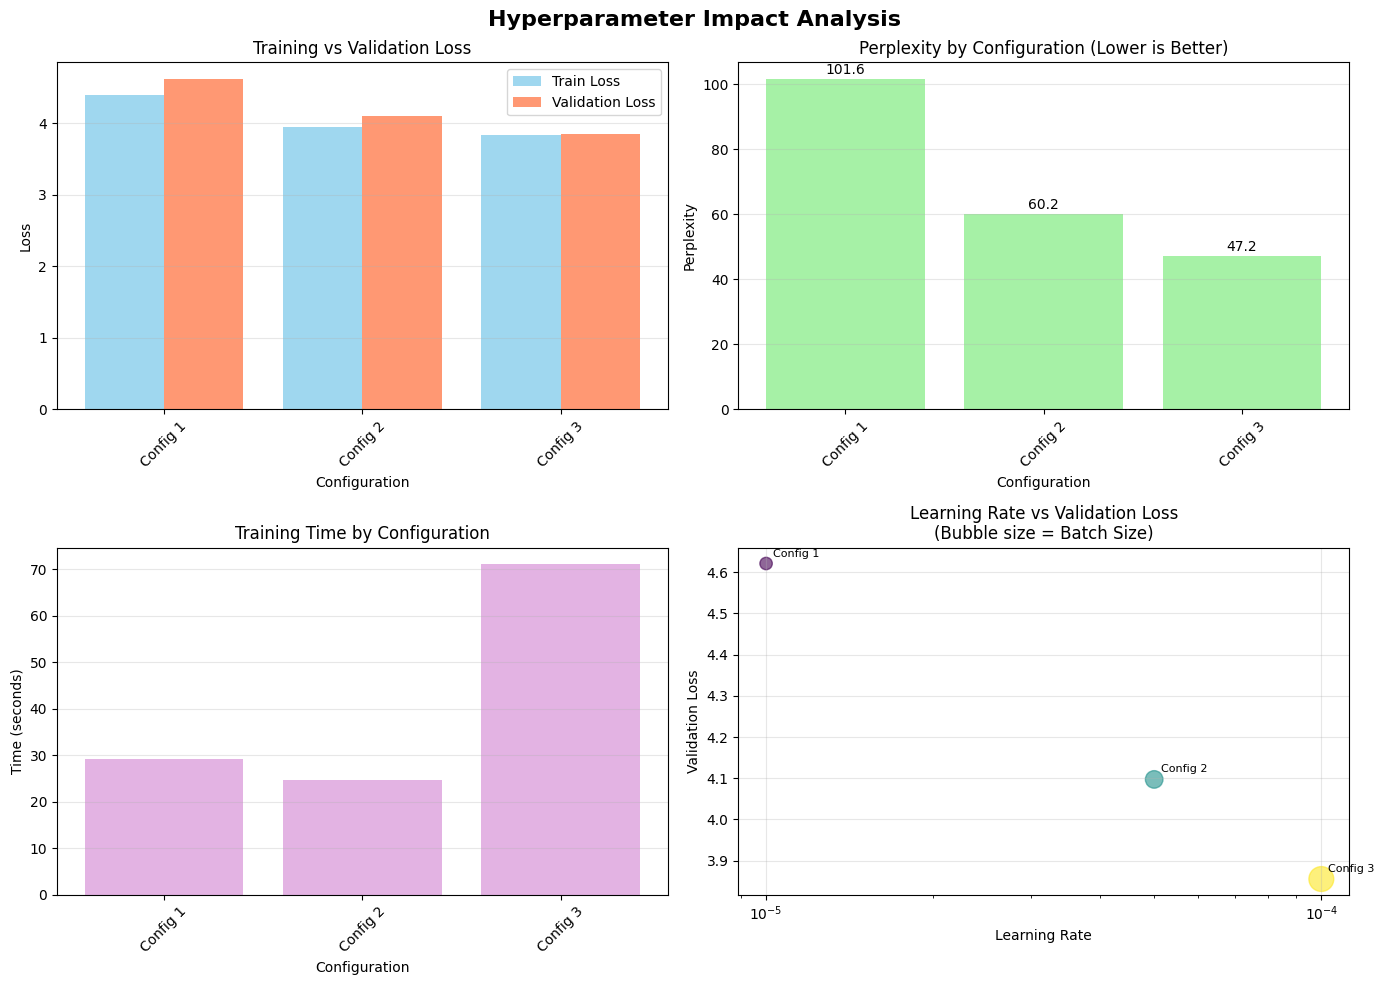


Visualization complete!


In [30]:
# Visualization 1: Loss Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hyperparameter Impact Analysis', fontsize=16, fontweight='bold')

# Plot 1: Train vs Validation Loss
x = range(len(results_df))
axes[0, 0].bar([i - 0.2 for i in x], results_df['Train Loss'], 
               width=0.4, label='Train Loss', alpha=0.8, color='skyblue')
axes[0, 0].bar([i + 0.2 for i in x], results_df['Validation Loss'], 
               width=0.4, label='Validation Loss', alpha=0.8, color='coral')
axes[0, 0].set_xlabel('Configuration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([f'Config {i+1}' for i in x], rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Perplexity Comparison
axes[0, 1].bar(x, results_df['Perplexity'], color='lightgreen', alpha=0.8)
axes[0, 1].set_xlabel('Configuration')
axes[0, 1].set_ylabel('Perplexity')
axes[0, 1].set_title('Perplexity by Configuration (Lower is Better)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([f'Config {i+1}' for i in x], rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(results_df['Perplexity']):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

# Plot 3: Training Time Comparison
axes[1, 0].bar(x, results_df['Training Time (s)'], color='plum', alpha=0.8)
axes[1, 0].set_xlabel('Configuration')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].set_title('Training Time by Configuration')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f'Config {i+1}' for i in x], rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Learning Rate vs Validation Loss
axes[1, 1].scatter(results_df['Learning Rate'], results_df['Validation Loss'], 
                   s=results_df['Batch Size']*20, alpha=0.6, c=range(len(results_df)),
                   cmap='viridis')
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('Validation Loss')
axes[1, 1].set_title('Learning Rate vs Validation Loss\n(Bubble size = Batch Size)')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(alpha=0.3)

# Add annotations for each point
for i, row in results_df.iterrows():
    axes[1, 1].annotate(f'Config {i+1}', 
                        (row['Learning Rate'], row['Validation Loss']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

## 8. Key Insights from Hyperparameter Tuning

In [31]:
# Generate insights
print("\n" + "="*80)
print("KEY INSIGHTS FROM HYPERPARAMETER TUNING")
print("="*80)

# Insight 1: Learning Rate Impact
lr_impact = results_df.sort_values('Learning Rate')
print("\n1. LEARNING RATE IMPACT:")
print("   Learning rate controls how much the model updates its weights.")
for idx, row in lr_impact.iterrows():
    print(f"   - LR={row['Learning Rate']:.0e}: Val Loss={row['Validation Loss']:.4f}, Perplexity={row['Perplexity']:.2f}")

# Insight 2: Batch Size Impact
bs_impact = results_df.sort_values('Batch Size')
print("\n2. BATCH SIZE IMPACT:")
print("   Larger batches provide more stable gradients but use more memory.")
for idx, row in bs_impact.iterrows():
    print(f"   - Batch Size={row['Batch Size']}: Training Time={row['Training Time (s)']:.2f}s")

# Insight 3: Trade-offs
print("\n3. PERFORMANCE vs SPEED TRADE-OFF:")
fastest = results_df.loc[results_df['Training Time (s)'].idxmin()]
best_perf = results_df.loc[results_df['Validation Loss'].idxmin()]
print(f"   - Fastest: {fastest['Configuration']} ({fastest['Training Time (s)']:.2f}s)")
print(f"   - Best Performance: {best_perf['Configuration']} (Loss={best_perf['Validation Loss']:.4f})")

# Insight 4: Overfitting Check
print("\n4. OVERFITTING ANALYSIS:")
for idx, row in results_df.iterrows():
    gap = row['Validation Loss'] - row['Train Loss']
    status = "Possible overfitting" if gap > 0.5 else "Good generalization"
    print(f"   - {row['Configuration']}: Gap={gap:.4f} → {status}")

print("\n" + "="*80)


KEY INSIGHTS FROM HYPERPARAMETER TUNING

1. LEARNING RATE IMPACT:
   Learning rate controls how much the model updates its weights.
   - LR=1e-05: Val Loss=4.6212, Perplexity=101.61
   - LR=5e-05: Val Loss=4.0971, Perplexity=60.17
   - LR=1e-04: Val Loss=3.8553, Perplexity=47.24

2. BATCH SIZE IMPACT:
   Larger batches provide more stable gradients but use more memory.
   - Batch Size=4: Training Time=29.19s
   - Batch Size=8: Training Time=24.71s
   - Batch Size=16: Training Time=71.04s

3. PERFORMANCE vs SPEED TRADE-OFF:
   - Fastest: Medium LR + Medium Batch (24.71s)
   - Best Performance: Large LR + Large Batch (Loss=3.8553)

4. OVERFITTING ANALYSIS:
   - Small LR + Small Batch: Gap=0.2320 → Good generalization
   - Medium LR + Medium Batch: Gap=0.1489 → Good generalization
   - Large LR + Large Batch: Gap=0.0145 → Good generalization

